In [1]:
# from pymer4.models import Lmer
# from statsmodels.formula.api import ols
# from statsmodels.stats.multitest import multipletests

# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import openpyxl

In [2]:
import pandas as pd
import numpy as np

In [3]:
rois_left = ['LaPU', 'LaCA', 'LpPU', 'LpCA']
rois_right = ['RaPU', 'RaCA', 'RpPU', 'RpCA']
rois_PU = ['LaPU','RaPU','LpPU','RpPU']
rois_CA = ['LaCA','RaCA','LpCA','RpCA']
rois_ant = ['LaPU', 'LaCA', 'RaPU', 'RaCA']
rois_post = ['LpPU', 'LpCA', 'RpPU', 'RpCA']

In [4]:
list_roi = rois_CA + rois_PU

In [5]:
list_group = np.array(['no_stim', 'DLPFC_cTBS', 'M1_cTBS', 'DLPFC_20Hz'])

In [6]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [7]:
df = pd.read_excel('/home/sungbeenpark/Github/labs/GP/results/performance_modulated_activity.8_striatum.xlsx')
df['stim'] = ['yes' if subj[1]!='A' else 'no' for subj in df.subj]
df['time'] = ['%d'%int(run[-2:]) for run in df.run]
df = df.astype({'time':int})
df

,subj,group,run,roi,beta,nvoxels,stim,time
0,GA01,no_stim,r01,RaPU,0.518611,135,no,1
1,GA01,no_stim,r01,LaPU,0.599993,133,no,1
2,GA01,no_stim,r01,LpPU,0.151185,132,no,1
3,GA01,no_stim,r01,RpPU,0.272298,105,no,1
4,GA01,no_stim,r01,LaCA,0.538827,71,no,1
...,...,...,...,...,...,...,...,...
1915,GP75,DLPFC_20Hz,r03,RpPU,0.614432,105,yes,3
1916,GP75,DLPFC_20Hz,r03,LaCA,0.917109,71,yes,3
1917,GP75,DLPFC_20Hz,r03,LpCA,0.538714,103,yes,3
1918,GP75,DLPFC_20Hz,r03,RaCA,1.086447,66,yes,3


### t-test

In [15]:
df_tmp.beta * df_tmp.nvoxels

0       70.012471
1       79.799052
2       19.956442
3       28.591297
4       38.256683
          ...    
1515    62.405233
1516    25.715393
1517    42.272324
1518    26.593499
1519    52.115106
Length: 720, dtype: float64

In [14]:
df_tmp = df[df.group=='no_stim']
df_tmp['beta_sum'] = df_tmp.beta * df_tmp.nvoxels
df_tmp.astype({'beta_sum':float})
df_tmp

/tmp/ipykernel_3169594/880124203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['beta_sum'] = df_tmp.beta * df_tmp.nvoxels


,subj,group,run,roi,beta,nvoxels,stim,time,beta_sum
0,GA01,no_stim,r01,RaPU,0.518611,135,no,1,70.012471
1,GA01,no_stim,r01,LaPU,0.599993,133,no,1,79.799052
2,GA01,no_stim,r01,LpPU,0.151185,132,no,1,19.956442
3,GA01,no_stim,r01,RpPU,0.272298,105,no,1,28.591297
4,GA01,no_stim,r01,LaCA,0.538827,71,no,1,38.256683
...,...,...,...,...,...,...,...,...,...
1515,GA44,no_stim,r03,RpPU,0.594336,105,no,3,62.405233
1516,GA44,no_stim,r03,LaCA,0.362189,71,no,3,25.715393
1517,GA44,no_stim,r03,LpCA,0.410411,103,no,3,42.272324
1518,GA44,no_stim,r03,RaCA,0.402932,66,no,3,26.593499


In [22]:
sum(df_tmp[(df_tmp.subj=='GA01')&(df_tmp.run=='r01')].beta_sum)

390.48575511574745

In [23]:
dg = df_tmp.groupby(
    ['subj','group','run','time'],
    as_index=False
).agg(
    beta_sum=('beta_sum', 'sum'),
)
dg

,subj,group,run,time,beta_sum
0,GA01,no_stim,r01,1,390.485755
1,GA01,no_stim,r02,2,365.071579
2,GA01,no_stim,r03,3,-333.186854
3,GA02,no_stim,r01,1,502.988786
4,GA02,no_stim,r02,2,52.215829
...,...,...,...,...,...
85,GA42,no_stim,r02,2,115.874986
86,GA42,no_stim,r03,3,271.208187
87,GA44,no_stim,r01,1,647.885902
88,GA44,no_stim,r02,2,501.467755


In [29]:
from scipy import stats

a = dg[dg.run=='r01'].set_index('subj').beta_sum
b = dg[dg.run=='r03'].set_index('subj').beta_sum

# a = a.sort_index()
# b = b.sort_index()

res = stats.ttest_rel(a,b)
tval, pval = res
print('t(%s)=%.5f (%.3e)'%(res.df, tval, pval))

t(29)=3.91747 (5.003e-04)


**Hierarchical Structure**

- level 1: subject (GA01 ~ GP75); this is the "$i$" in the equation.
- level 2: group (baseline ~ DLPFC_20Hz); this is the "$j$" in the equation.
- level 3: TMS (no stim vs stim); This level is not modeled in the LMM equation.

In [8]:
# # Check the rest of new data (data before GP71) is the same as the old data.
# df = pd.read_excel('./data/Rew#1_Coef_filtered_new_KJH.xlsx')
# merged_df = pd.merge(df, df_n50, on=['subj', 'group', 'run', 'roi', 'time'], suffixes=('_1', '_n50'))
# merged_df['beta_same'] = merged_df['beta_1'] == merged_df['beta_n50']
# all(merged_df['beta_same'])

In [8]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

---

## Note

StatsModels formula api uses `Patsy` to handle passing the formulas. The pseudo code looks like the following:
```
smf.mixedlm("dependent_variable ~ independent_variable1 + independent_variable2 + independent_variablen", data = df).fit()
```

To tell the model that a variable is categorical, it needs to be wrapped in C(independent_variable). The pseudo code with a categorical independent variable looks like:
```
smf.mixedlm("dependent_variable ~ independent_variable1 + C(independent_variable2)", data = df).fit()
```

By default, `Patsy` chooses the first categorical variable as the reference category; it's possible to change the reference category if desired. In order to do this, one needs to specify the reference category while one is specifying the variable is a categorical variable. Pseduo code is as follows:
```
smf.mixedlm("dependent_variable ~ independent_variable1 + C(independent_variable2, Treatment(categorical_group))", data = df).fit()
```

Where categorical_group is the desired reference group.

[pythonfordatascience](https://www.pythonfordatascience.org/mixed-effects-regression-python/#:~:text=Mixed%20effect%20models%20are%20also%20known%20as)

---

### Random Intercept Model

1. $\beta \sim time + (1|subject)$ or $\beta \sim time + 1$ or $\beta \sim time$ ; These are the same notation

$1$ means a random intercept
- fixed effect : **time**
- randome effect : **subject** (*no-stim* group)

### linear mixed-effects (LME) model to examine the fMRI activity over time for the 'No-stim' group.

LaPU (dof=88)
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: beta    
No. Observations: 90      Method:             REML    
No. Groups:       30      Scale:              0.0602  
Min. group size:  3       Log-Likelihood:     -29.8122
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.734    0.087  8.433 0.000  0.564  0.905
time        -0.133    0.032 -4.198 0.000 -0.195 -0.071
Group Var    0.087    0.140                           



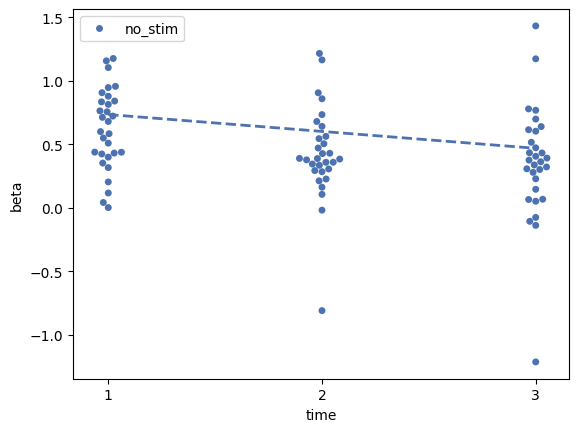

In [9]:
roi = 'LaPU'
df_tmp = df[(df.group=='no_stim')&(df.roi==roi)]
# df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
model = smf.mixedlm("beta ~ time", df_tmp, groups=df_tmp['subj'])
result = model.fit()
print('%s (dof=%d)'%(roi,result.df_resid))
print(result.summary())

palette = sns.color_palette("deep", len(df_tmp.group.unique()))

g = sns.swarmplot(
    data=df_tmp,
    x='time', y='beta', hue='group', palette=palette
)
g.legend(title='')
x = np.array([0,1,2])
y = x * result.params.time + result.params.Intercept

g.plot(
    x,y,
    label='slope=%.4f'%result.params.time,
    linestyle='--', linewidth=2,
    color=palette[0]
)

**Intercept** : This represents the baseline value of the dependent variable (=$\beta$) when all other predictors are zero (when *time*=0 and *group=baseline*; the reference group). It is the starting point of the model.

**time** : This represents the effect of *time* on $\beta$. It shows how $\beta$ changes over *time*.

LaCA (dof=88): **p=0.0041 uncorrected / *p=0.0326 corrected
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: beta    
No. Observations: 90      Method:             REML    
No. Groups:       30      Scale:              0.0549  
Min. group size:  3       Log-Likelihood:     -22.6488
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.513    0.079  6.466 0.000  0.357  0.668
time        -0.087    0.030 -2.872 0.004 -0.146 -0.028
Group Var    0.060    0.108                           

RaCA (dof=88): **p=0.0011 uncorrected / **p=0.0084 corrected
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: beta    
No. Observations: 90      Method:             REML    
No. Groups:     

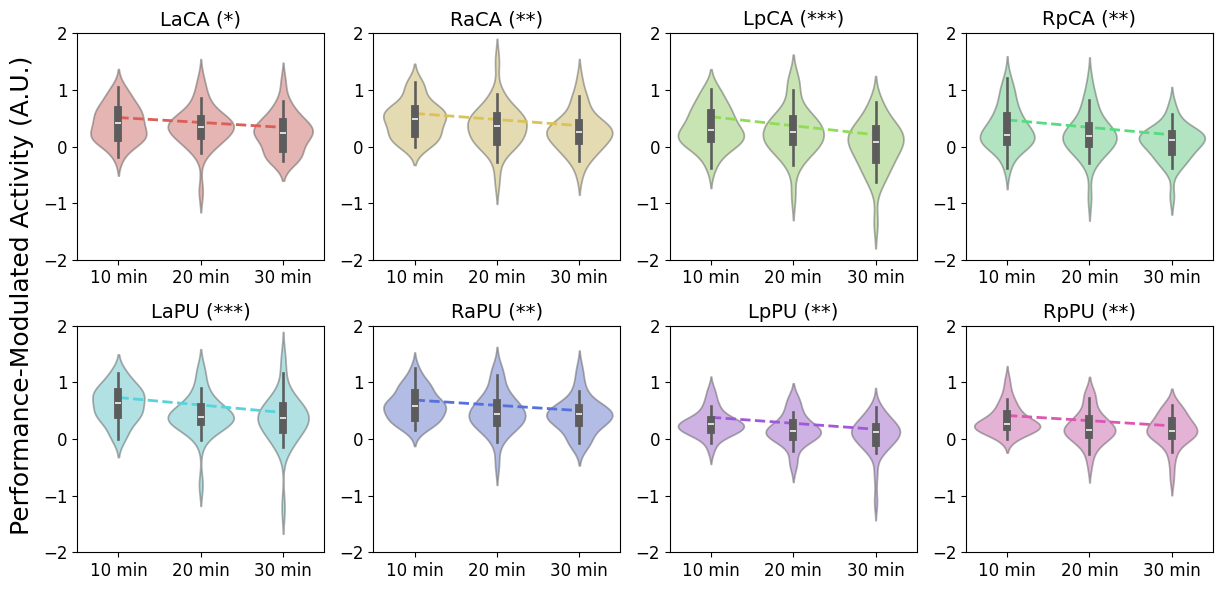

In [10]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
axs = np.reshape(axs, -1)
palette = sns.color_palette("hls", len(list_roi))
x = np.array([0,1,2])

for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    df_tmp = df[(df.group=='no_stim')&(df.roi==roi)]
    model = smf.mixedlm("beta ~ time + 1", df_tmp, groups=df_tmp['subj'])
    result = model.fit()
    pval = result.pvalues.time    

    y = x * result.params.time + result.params.Intercept
    ax.plot(
        x,y,
        label='slope=%.4f'%result.params.time,
        linestyle='--', linewidth=2,
        color=palette[ii]
    )
    # g = sns.swarmplot(
    #     data=df_tmp,
    #     x='time', y='beta', color=palette[ii],
    #     ax=ax
    # )
    g = sns.violinplot(
        data=df_tmp,
        x='time', y='beta', color=palette[ii],
        alpha = 0.5,
        ax=ax
    )
    g.legend().remove()
    g.set_xticks([0, 1, 2])
    g.set_xticklabels(['10 min', '20 min', '30 min'], fontsize=12)
    g.set_xlabel('', fontsize=0)

    g.tick_params(axis='y', labelsize=12)
    g.set_ylim([-2, 2])
    g.set_ylabel('', fontsize=0)
    
    # *8 means a correction (8 ROIs)
    pval_c = pval * 8

    roi_ = roi[0].upper()+roi[1:]
    g.set_title('%s (%s)'%(roi_, convert_pvalue_to_asterisks(pval_c)), fontsize=14)
    print('%s (dof=%d): %sp=%.4f uncorrected / %sp=%.4f corrected'%
        (roi, result.df_resid, convert_pvalue_to_asterisks(pval), pval, convert_pvalue_to_asterisks(pval_c), pval_c)
    )
    print(result.summary())

fig.text(-.015, 0.5, 'Performance-Modulated Activity (A.U.)', va='center', rotation='vertical', fontsize=18)

fig.tight_layout()

In [13]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.S1b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

2. $\beta \sim time * group + (1|sujbect)$ or $\beta \sim time + C(group, Treatment(reference)) + time:C(group, Treatment(reference))$
- fixed effect : **time**, **group** (possibly correlated)
- random effect : **subject**

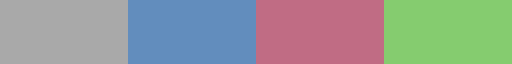

In [13]:
from matplotlib import cm, colors, patches, lines

# palette = sns.color_palette("deep", len(df_tmp.group.unique()))
# palette = ["#000000", "#1f77b4", "#ff7f0e", "#2ca02c"]
# palette = sns.color_palette("deep", len(list_roi))
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']
cmap = colors.ListedColormap(palette)
cmap

i) Reference group = No-stim

In [14]:
group_ref = 'baseline'

Reference Group = baseline

laCA (dof=232)
baseline -> DLPFC_cTBS : ***p=0.00021 uncorrected / **p=0.00169 corrected
baseline -> M1_cTBS : nsp=0.79819 uncorrected / nsp=6.38553 corrected
baseline -> DLPFC_20Hz : nsp=0.41524 uncorrected / nsp=3.32196 corrected
                            Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              beta    
No. Observations:              240                  Method:                          REML    
No. Groups:                    80                   Scale:                           0.0498  
Min. group size:               3                    Log-Likelihood:                  -56.6084
Max. group size:               3                    Converged:                       Yes     
Mean group size:               3.0                                                           
---------------------------------------------------------------------------------------------
                

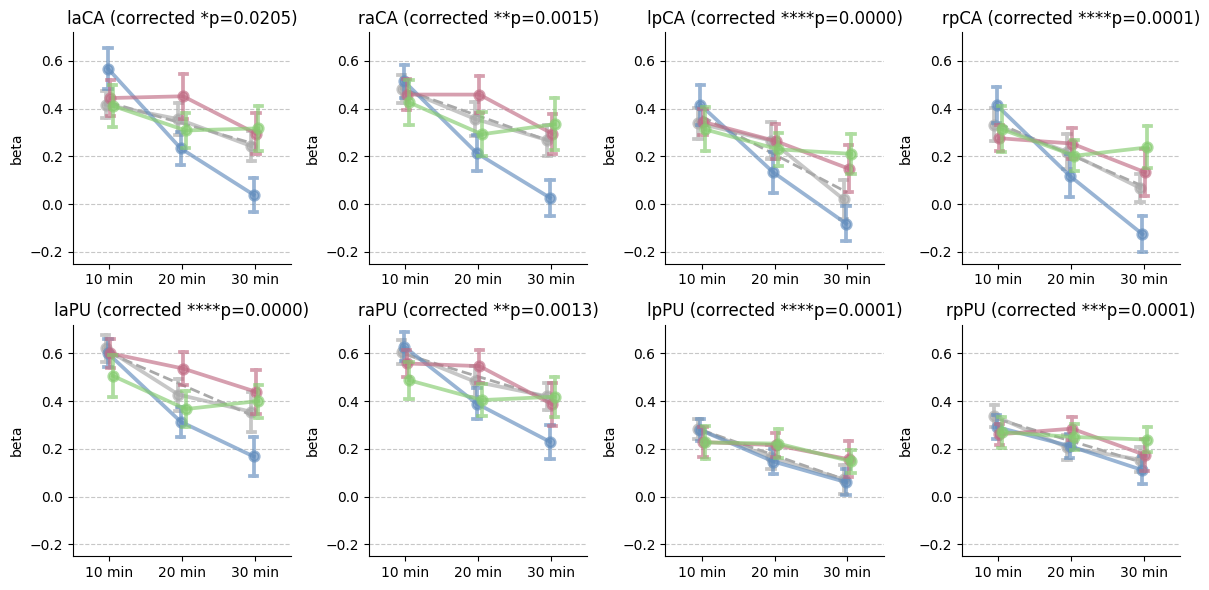

In [15]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
axs = np.reshape(axs, -1)
x = np.array([0,1,2])

print('Reference Group = %s\n'%group_ref)
for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    df_tmp = df_n50[df_n50['roi']==roi]
    model = smf.mixedlm(
        "beta ~ time + C(group, Treatment('%s')) + time:C(group, Treatment('%s'))"%(group_ref,group_ref),
        df_tmp,
        groups=df_tmp['subj']
    )
    result = model.fit()

    ## plotting figure
    y = x * result.params.time + result.params.Intercept
    ax.plot(
        x,y,
        label='slope=%.4f'%result.params.time,
        linestyle='--', linewidth=2,
        color=palette[0] # No-stim
    )
    
    # *8 means a correction (8 ROIs)
    pval = result.pvalues.time*8
    ax.set_title('%s (corrected %sp=%.4f)'%(roi, convert_pvalue_to_asterisks(pval), pval))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    g = sns.pointplot(
        data=df_tmp,
        x='time', y='beta', hue='group', hue_order=list_group,
        errorbar='se', capsize=0.1,
        dodge=True,
        palette=palette, alpha=0.65,
        ax=ax
    )
    g.legend().remove()
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g.set_xticks([0, 1, 2])
    g.set_xticklabels(['10 min', '20 min', '30 min'])
    g.set_xlabel('', fontsize=0)

    g.set_ylim([-0.25,.72])

    # cnt = 0
    print('%s (dof=%d)'%(roi,result.df_resid))
    for gg in list_group[list_group != group_ref]:
        ss = "time:C(group, Treatment('%s'))[T.%s]"%(group_ref,gg)
        pval = result.pvalues[ss]
        pval_c = pval * 8  # '*8' is a correction factor
        print('%s -> %s : %sp=%.5f uncorrected / %sp=%.5f corrected'%
            (group_ref,gg,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
        )
    #     if pval < 0.05:
    #         print('%s (dof=%d)'%(roi,result.df_resid))
    #         print('%s -> %s : %sp=%.5f uncorrected / %sp=%.5f corrected'%
    #             (group_ref,gg,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
    #         )
    #         cnt += 1
    # if cnt > 0:
    print(result.summary())

fig.tight_layout()

**C(group, Treatment('baseline'))[T.DLPFC_cTBS]** : This indicates the effect of the *DLPFC$_{cTBS}$* group compared to the *reference group*. It shows how being in the *baseline* group changes $\beta$.

**time:C(group, Treatment('baseline'))[T.DLPFC_cTBS]** : This interaction term shows how the effect of *time* on $\beta$ differs between the *DLPFC$_{cTBS}$* group and the reference group (=*baseline*). It indicates whether the *time* effect is different for the *baseline* group.

ii) Reference group = DLPFC$_{20Hz}$

In [16]:
group_ref = 'DLPFC_20Hz'

Reference Group = DLPFC_20Hz

laCA (dof=232)
DLPFC_20Hz -> baseline : nsp=0.41524 uncorrected / nsp=3.32196 corrected
DLPFC_20Hz -> DLPFC_cTBS : ****p=0.00008 uncorrected / ***p=0.00062 corrected
DLPFC_20Hz -> M1_cTBS : nsp=0.61621 uncorrected / nsp=4.92968 corrected
                             Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              beta    
No. Observations:                240                  Method:                          REML    
No. Groups:                      80                   Scale:                           0.0498  
Min. group size:                 3                    Log-Likelihood:                  -56.6084
Max. group size:                 3                    Converged:                       Yes     
Mean group size:                 3.0                                                           
-----------------------------------------------------------------------------------------

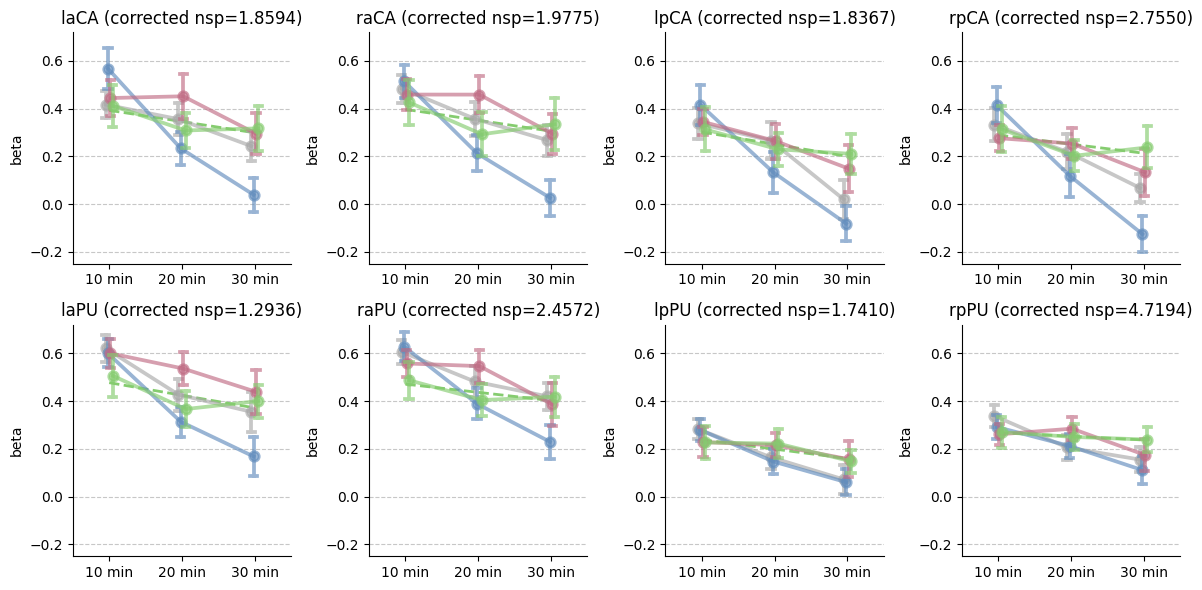

In [17]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
axs = np.reshape(axs, -1)
x = np.array([0,1,2])

print('Reference Group = %s\n'%group_ref)
for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    df_tmp = df_n50[df_n50['roi']==roi]
    model = smf.mixedlm(
        "beta ~ time + C(group, Treatment('%s')) + time:C(group, Treatment('%s'))"%(group_ref,group_ref),
        df_tmp,
        groups=df_tmp['subj']
    )
    result = model.fit()

    ## plotting figure
    y = x * result.params.time + result.params.Intercept
    ax.plot(
        x,y,
        label='slope=%.4f'%result.params.time,
        linestyle='--', linewidth=2,
        color=palette[-1] # DLPFC_20Hz
    )
    
    # *8 means a correction (8 ROIs)
    pval = result.pvalues.time*8
    ax.set_title('%s (corrected %sp=%.4f)'%(roi, convert_pvalue_to_asterisks(pval), pval))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    g = sns.pointplot(
        data=df_tmp,
        x='time', y='beta', hue='group', hue_order=list_group,
        errorbar='se', capsize=0.1,
        dodge=True,
        palette=palette, alpha=0.65,
        ax=ax
    )
    g.legend().remove()
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g.set_xticks([0, 1, 2])
    g.set_xticklabels(['10 min', '20 min', '30 min'])
    g.set_xlabel('', fontsize=0)

    g.set_ylim([-0.25,.72])

    # cnt = 0
    print('%s (dof=%d)'%(roi,result.df_resid))
    for gg in list_group[list_group != group_ref]:
        ss = "time:C(group, Treatment('%s'))[T.%s]"%(group_ref,gg)
        pval = result.pvalues[ss]
        pval_c = pval * 8  # '*8' is a correction factor
        print('%s -> %s : %sp=%.5f uncorrected / %sp=%.5f corrected'%
            (group_ref,gg,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
        )
    #     if pval < 0.05:
    #         print('%s (dof=%d)'%(roi,result.df_resid))
    #         print('%s -> %s : %sp=%.5f uncorrected / %sp=%.5f corrected'%
    #             (group_ref,gg,convert_pvalue_to_asterisks(pval),pval,convert_pvalue_to_asterisks(pval_c),pval_c)
    #         )
    #         cnt += 1
    # if cnt > 0:
    print(result.summary())

fig.tight_layout()

---

---

### Random slope model

In [ ]:
## random slope model (=random intercept and slope model)

print(roi)
df_tmp = df_n50[df_n50['roi']==roi]
# df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
model = smf.mixedlm(
    "beta ~ time * C(group, Treatment('baseline'))",
    df_tmp,
    groups=df_tmp['subj'],
    re_formula="1 + time"
)
# model = smf.mixedlm("beta ~ time", df_tmp, groups=df_tmp['subj'])
result = model.fit()
print(result.summary())

In [ ]:
g = sns.swarmplot(
    data=df_tmp,
    x='time', y='beta',
    hue='group', hue_order=list_group, palette=palette
)
g.legend(title='')

# *3 means a correction (The degrees of freedom for the ROI is 3)
pval = result.pvalues["time:C(group, Treatment('baseline'))[T.DLPFC_cTBS]"] * 3
g.set_title('%s (%sp=%.4f)'%(roi, convert_pvalue_to_asterisks(pval), pval))

## A group that draws a line with a significant p-value for the slope.
list_line = []
for gg in list_group[1:]:
    ss = "time:C(group, Treatment('baseline'))[T.%s]"%gg
    pval_corrected = result.pvalues[ss] * 3
    # print(pval_corrected)
    if pval_corrected < 0.05:
        list_line.append(ss)
# print(list_line)

x = np.array([0,1,2])
# for ss in list_line:
# y = x * result.params[ss] + result.params.Intercept
# g.plot(
#     x,y,
#     label='slope=%.4f'%result.params.time,
#     linestyle='--', linewidth=2,
#     color=palette[1]
# )

In [ ]:
result.params["time:C(group, Treatment('baseline'))[T.DLPFC_cTBS]"]

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
axs = np.reshape(axs, -1)
palette = sns.color_palette("husl", 3)
x = np.array([0,1,2])

for ii, roi in enumerate(list_roi):
    ax = axs[ii]

    df_tmp = df_n50[df_n50['roi']==roi]
    model = smf.mixedlm("beta ~ time * group", df_tmp, groups=df_tmp['subj'])
    result = model.fit()
    # print(result.summary())

    g = sns.swarmplot(
        data=df_tmp,
        x='time', y='beta',
        hue='group', hue_order=list_group, palette=palette,
        ax=ax
    )
    g.legend().remove()
    g.set_xticks([0, 1, 2])
    g.set_xticklabels(['10 min', '20 min', '30 min'])
    g.set_xlabel('', fontsize=0)

    ## slope: time
    y = x * result.params.time + result.params.Intercept
    ax.plot(
        x,y,
        label='slope=%.4f'%result.params.time,
        linestyle='--', linewidth=2,
        color='b'
    )
    
    # # *8 means a correction (8 ROIs)
    # pval = result.pvalues.time*8
    # g.set_title('%s (%sp=%.4f)'%(roi, convert_pvalue_to_asterisks(pval), pval))

    # ## group
    # y = x * result.params.group + result.params.Intercept
    # ax.plot(
    #     x,y,
    #     label='slope=%.4f'%result.params.group,
    #     linestyle='--', linewidth=2,
    #     color=palette[ii]
    # )
    # # ax.legend().remove()
    # g = sns.swarmplot(
    #     data=df_tmp,
    #     x='time', y='beta', hue='group', palette=palette,
    #     ax=ax
    # )
    # g.set_xticks([0, 1, 2])
    # g.set_xticklabels(['10 min', '20 min', '30 min'])
    # g.set_xlabel('', fontsize=0)
    
    # # *8 means a correction (8 ROIs)
    # pval = result.pvalues.time*8
    # g.set_title('%s (%sp=%.4f)'%(roi, convert_pvalue_to_asterisks(pval), pval))
    
fig.tight_layout()

In [ ]:
for ii, clr in enumerate(palette):
    dx = 0.25*ii
    x, y = 0 + dx, 0
    w, h = 0.045, 0.1
    nax.add_patch(Rectangle((x,y),w , h, facecolor=clr, edgecolor='k'))
    nax.text(x+.085, y, gg, fontsize=13, horizontalalignment='left', verticalalignment='bottom')
    
nax.axis('off')
fig

---